<a href="https://colab.research.google.com/github/yesong98/Exploration/blob/main/Exploration16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⭐️프로젝트 : Segmentation map으로 도로 이미지 만들기⭐️
<루브릭>


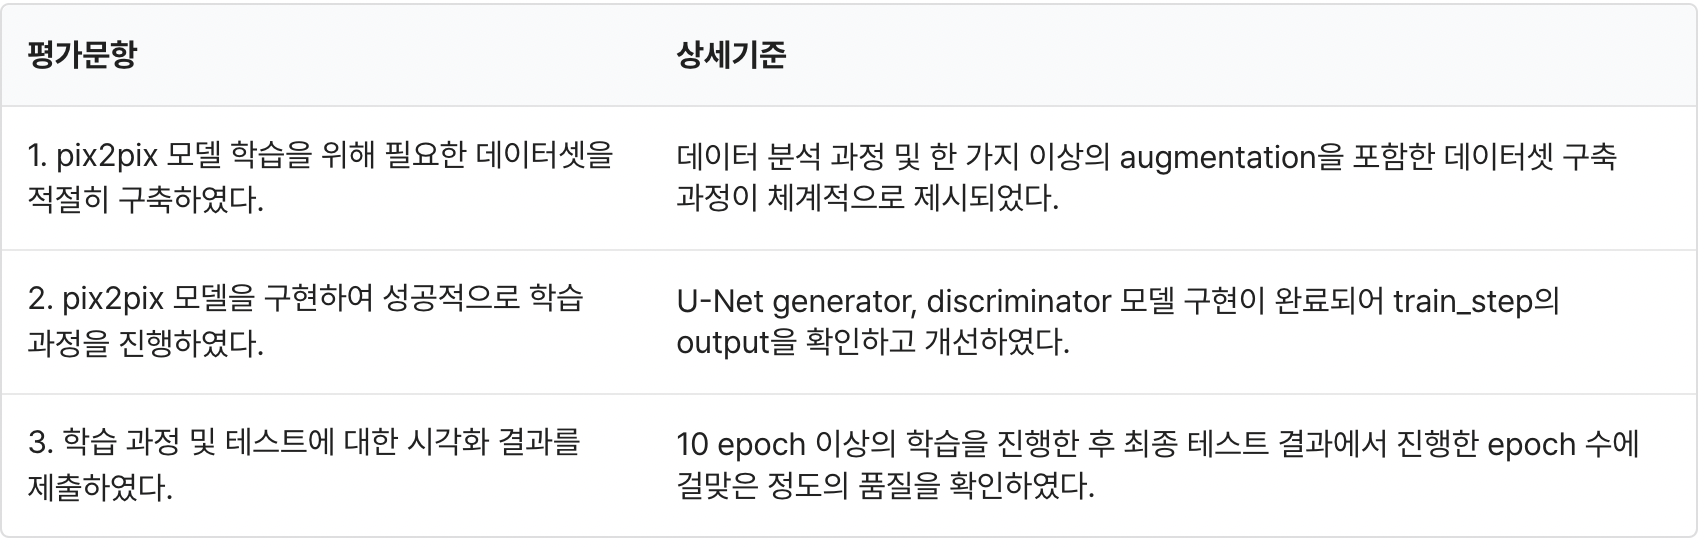

## 프로젝트 수행
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

- 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.
(어떠한 방법을 사용했는지 적어주세요.)
- 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.
- 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
- 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
- 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

## 1) 데이터 준비

In [ ]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)
print(tensorflow.keras.__version__)

1.21.6
2.8.2
2.8.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow.keras import layers, Input, Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip list | grep tensorflow-dataset

tensorflow-datasets           4.6.0


In [ ]:
#이미지 개수 확인
data_path = '/content/drive/MyDrive/aiffel/cityscapes/train/'

# os.listdir()은 지정한 디렉터리 내의 모든 파일과 디렉터리의 리스트를 출력합니다.
print('number of train examples:',len(os.listdir(data_path)))

number of train examples: 1000


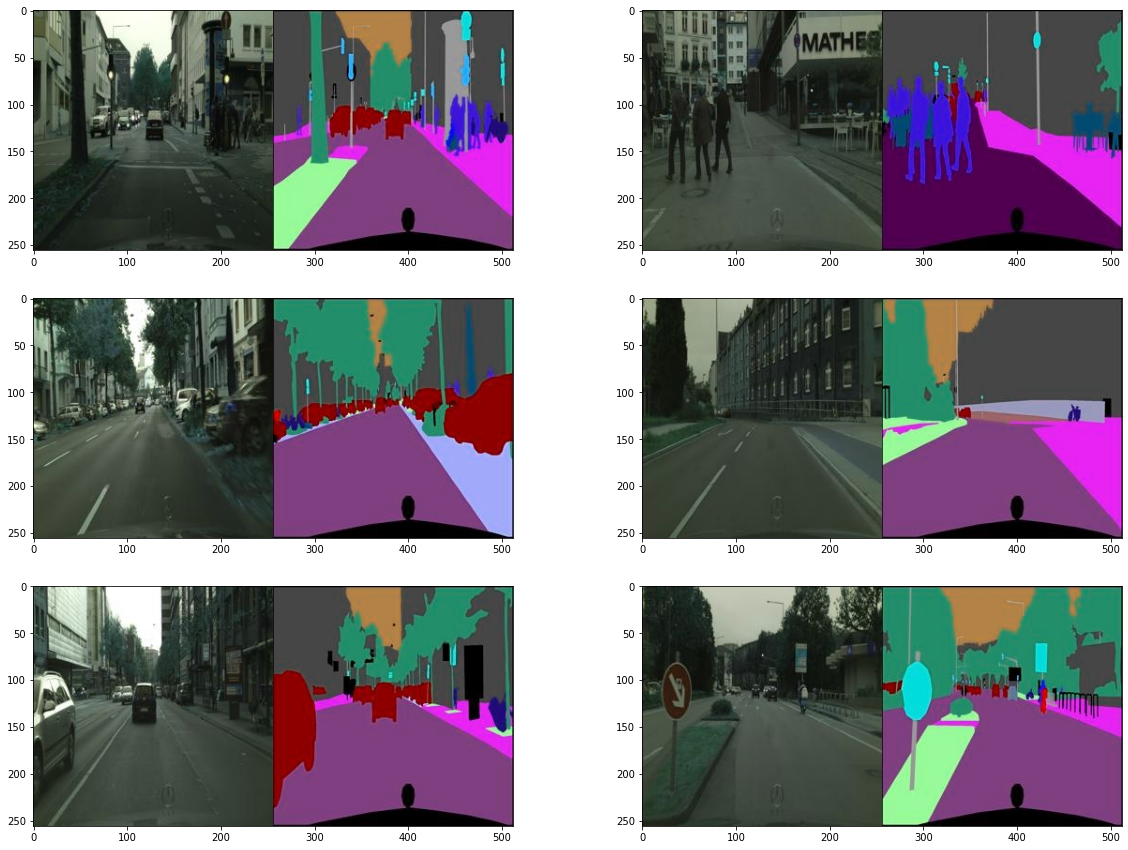

In [ ]:
plt.figure(figsize=(20,15))
for i in range(1,7):
  f = data_path + os.listdir(data_path)[np.random.randint(1000)]
  img = cv2.imread(f, cv2.IMREAD_COLOR)  # cv2.IMREAD_COLOR는 이미지파일을 컬러로 읽어드립니다.
  plt.subplot(3,2,i)
  plt.imshow(img)

In [ ]:
#이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


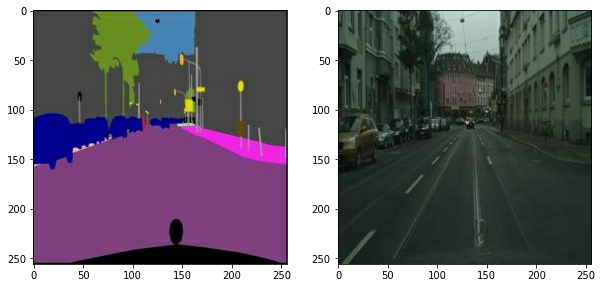

In [ ]:
#두개 이미지로 나누기
def normalize(x):
  x = tf.cast(x, tf.float32) # tf.cast()는 괄호안에 들어가는 배열의 dtype을 원하는 dtype으로 바꿔줍니다. 
  return (x/127.5) - 1 

def denormalize(x):
  x = (x+1)*127.5
  x = x.numpy()
  return x.astype(np.uint8)

def load_img(img_path):
  img = tf.io.read_file(img_path) # 이미지를 읽어옵니다.
  img = tf.image.decode_image(img, 3)

  w = tf.shape(img)[1] // 2  # 이미지의 가로길이설정
  colored = img[:, :w, :]
  colored = tf.cast(colored, tf.float32)
  segmentation = img[:, w:, :]
  segmentation = tf.cast(segmentation, tf.float32)
  return normalize(segmentation), normalize(colored)

f = data_path + os.listdir(data_path)[1]
segmentation, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segmentation))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## 2)Augmentation

In [ ]:
#여러 augmentation 방법 적용
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다.
def apply_augmentation(segmentation, colored):
  stacked = tf.concat([segmentation, colored], axis=-1) # 두이미지가 채널축으로 연결됩니다.

  _pad = tf.constant([[30,30], [30,30], [0,0]]) # tf.constant() 괄호안의 수나 배열을 텐서로만들어줌
  if tf.random.uniform(()) < .5:  # tf.random.uniform(()는 원하는 형태의 랜덤한 배열을 만듭니다.
    padded = tf.pad(stacked, _pad, "REFLECT")
  else:
    padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)  # tf.pad()은 지정한 패딩에따라 텐서를 채웁니다.

  out = image.random_crop(padded, size=[256, 256, 6])
  out = image.random_flip_left_right(out)
  out = image.random_flip_up_down(out)

  if tf.random.uniform(()) < .5:
    degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
    out = image.rot90(out, k=degree)

  return out[...,:3], out[...,3:]

#### **데이터에 apply_augmentation 적용하기**
- 두 이미지가 채널 축으로 연결됩니다. 두 이미지가 각각 3채널인 경우 6채널이 됩니다.  
- 50%확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다.  
- 방금의 결과에서 (256,256,6)크기를 가진 이미지를 임의로 잘라냅니다.  
- 50%확률로 가로로 뒤집습니다.  
- 50%확률로 세로로 뒤집습니다.  
- 50%확률로 회전시킵니다.

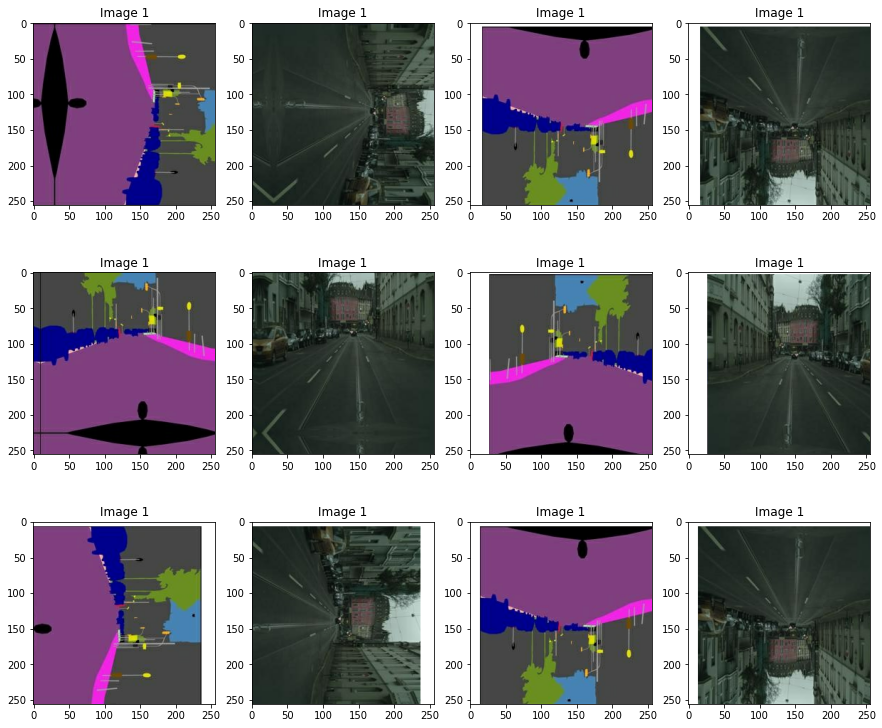

In [ ]:
# 시각화
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
  augmented_segmentation, augmented_colored = apply_augmentation(segmentation, colored)
  plt.subplot(3,4,i)
  plt.imshow(denormalize(augmented_segmentation)); plt.title(f"Image {img_n}")
  plt.subplot(3,4,i+1)
  plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")

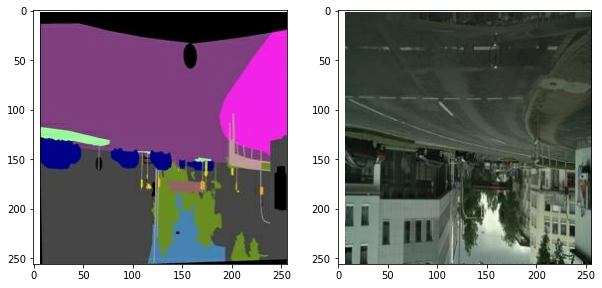

In [ ]:
# 이미지 하나 확인
from tensorflow import data

def get_train(img_path):
    segmentation, colored = load_img(img_path)
    segmentation, colored = apply_augmentation(segmentation, colored)
    return segmentation, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segmentation, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segmentation[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

![https://d3s0tskafalll9.cloudfront.net/media/images/refer_g.max-800x600.png](https://d3s0tskafalll9.cloudfront.net/media/images/refer_g.max-800x600.png)

## 3)Generator구성하기(U-Net)
**Encode** : in"이라고 쓰여진 입력 부분부터 윗줄의 화살표를 쭉 따라가면 계산된 결과의 (width, height) 크기가 점점 절반씩 줄어들며 최종적으로 (1,1)이 되고, (1,1,512) 크기를 출력하는 곳까지가 Encoder 부분입니다.  
**Decode** : (width, height) 크기가 점점 두 배로 늘어나 다시 (256, 256) 크기가 되고, 채널의 수는 점점 줄어들어 처음 입력과 같이 3채널이 됩니다. (1,1,512)를 입력으로 최종 출력까지의 연산들이 Decoder 부분입니다.   
*  "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었습니다.

In [ ]:
# 인코더 및 디코더에 사용되는 기본적인 블록입니다.
class EncodeBlock(layers.Layer):
  def __init__(self, n_filters, use_bn=True):
    super(EncodeBlock, self).__init__()
    self.use_bn = use_bn
    self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
    self.batchnorm = layers.BatchNormalization()
    self.lrelu = layers.LeakyReLU(0.2)

  def call(self, x):
    x = self.conv(x)
    if self.use_bn:
      x = self.batchnorm(x)
    return self.lrelu(x)

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

Encoder().get_summary()      

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

In [ ]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

In [ ]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## 4) Generator 재구성

In [ ]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [ ]:
class UNetGenerator(Model):
  def __init__(self):
    super(UNetGenerator, self).__init__()
    encode_filters = [64,128,256,512,512,512,512,512]
    decode_filters = [512,512,512,512,256,128,64]

    self.encode_blocks = []
    for i, f in enumerate(encode_filters):
      if i == 0:
        self.encode_blocks.append(EncodeBlock(f, use_bn=False))
      else:
        self.encode_blocks.append(EncodeBlock(f))
    
    self.decode_blocks = []
    for i, f in enumerate(decode_filters):
      if i < 3:
        self.decode_blocks.append(DecodeBlock(f))
      else:
        self.decode_blocks.append(DecodeBlock(f, dropout=False))
    
    self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)

  def call(self, x):
    features = []
    for block in self.encode_blocks:
      x = block(x)
      features.append(x)

    features = features[:-1] # 인코더의 마지막 출력은 디코더에 직접 입력되므로 제외합니다.

    for block, feat in zip(self.decode_blocks, features[::-1]): # features[::-1] : features에는 인코더블록들의 출력들이 순서대로쌓여있기때문에, 디코더에서는 역순으로 연결합니다.
      x = block(x)
      x = layers.Concatenate()([x, feat])

    x = self.last_conv(x)
    return x

  def get_summary(self, input_shape=(256,256,3)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

In [ ]:
# 완성된 U-Net구조 Generator내부의 각 출력이 적절한지 확인해봅니다.
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

이전 Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만 개였는데, Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개로 꽤나 많이 늘어났습니다.

##5) Discriminator 구성하기 
사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act

        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)

        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None

    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)

        if self.use_bn:
            x = self.batchnorm(x)

        if self.act:
            x = self.lrelu(x)
        return x

In [ ]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_45 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

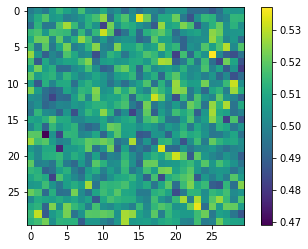

In [ ]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

##6)모델 학습

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [ ]:
#옵티마이저 설정
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했습니다.

In [ ]:
@tf.function
def train_step(segmentation, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(segmentation, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segmentation, fake_colored, training=True)
        real_disc = discriminator(segmentation, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
EPOCH[11] - STEP[10]                     
Generator_loss:1.0242                     
L1_loss:0.1657                     
Discriminator_loss:0.6624

EPOCH[11] - STEP[20]                     
Generator_loss:1.8395                     
L1_loss:0.1651                     
Discriminator_loss:0.4596

EPOCH[11] - STEP[30]                     
Generator_loss:0.7636                     
L1_loss:0.1789                     
Discriminator_loss:0.7597

EPOCH[11] - STEP[40]                     
Generator_loss:0.7261                     
L1_loss:0.1859                     
Discriminator_loss:1.4153

EPOCH[11] - STEP[50]                     
Generator_loss:0.3442                     
L1_loss:0.1767                     
Discriminator_loss:1.5679

EPOCH[11] - STEP[60]                     
Generator_loss:0.5440                     
L1_loss:0.1872                     
Discriminator_loss:1.6585

EPOCH[11] - STEP[70]                     
Generator_loss:1.6249             

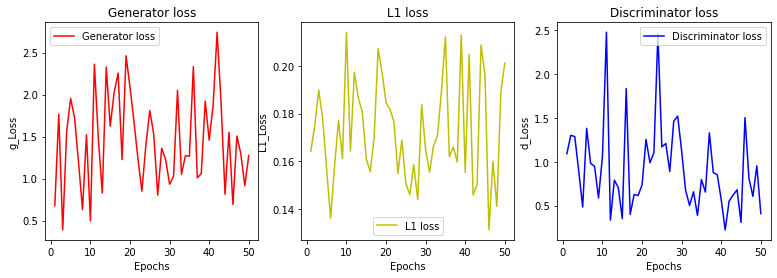

In [ ]:
EPOCHS = 50
fig = plt.figure(figsize=(13,4))
g = []
l1 = []
d = []

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
    g.append(g_loss.numpy())
    l1.append(l1_loss.numpy())
    d.append(d_loss.numpy())

epochs = range(1, len(g)+1)

ax1 = fig.add_subplot(1,3,1)
plt.plot(epochs, g, 'r', label='Generator loss')
plt.title('Generator loss')
plt.xlabel('Epochs')
plt.ylabel('g_Loss')
plt.legend()

ax2 = fig.add_subplot(1,3,2)
plt.plot(epochs, l1, 'y', label='L1 loss')
plt.title('L1 loss')
plt.xlabel('Epochs')
plt.ylabel('L1_Loss')
plt.legend()

ax3 = fig.add_subplot(1,3,3)
plt.plot(epochs, d, 'b', label='Discriminator loss')
plt.title('Discriminator loss')
plt.xlabel('Epochs')
plt.ylabel('d_Loss')
plt.legend()

##7)테스트


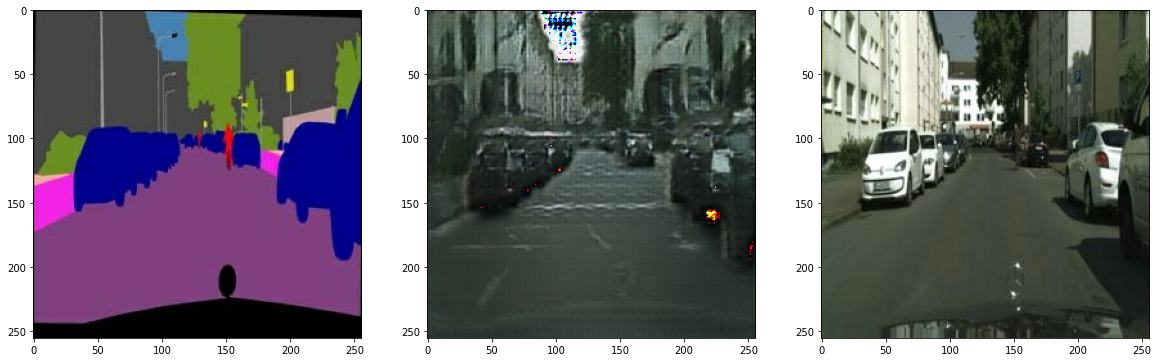

In [ ]:
test_path = '/content/drive/MyDrive/aiffel/cityscapes/val/'

f = test_path + os.listdir(test_path)[2]
segmentation, colored = load_img(f)

pred = generator(tf.expand_dims(segmentation, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segmentation))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## 📓결과
- epoch를 다양하게 해보았다
- 결과적으론 epoch=10일때가 가장 좋은 결과를 보였다. 학습을 많이 할수록 좋을 것이라 생각했는데 나의 생각과는 반대의 상황이 벌어져 당황스러웠다.
- epoch을 한번 돌리고 나서 재실행을 하지 않고 계속 돌렸더니 전에 epoch에 이어서 실행이 되어 이미지가 제대로 생성되지 않았다
- epoch를 재실행 할때 마다 런타임을 다시시작시켜 주었다
- 확실히 좋아진 이미지를 얻을 수 있었다
- epoch를 10에서 했을때 segmentation이 많이 제거 되었다고 생각했는데 epoch를 50으로 올리니 차의 모양도 선명해지고 도로도 더 명확해졌다. 하지만 건물과 자동차의 색이 뚜렷하지 않았다.
- epoch을 높일 수록 더 좋은 결과를 얻는다는 것을 확인할 수 있었다.
- - 그런데 한편으론 epoch이 높을 수록 더 좋은 결과가 나온다고 확신할 수 있을지 의문이다. 다른 분들이 하시는걸 봤을때 별로 차이가 없는 분들도 계셨다.

#### (1)epoch = 10





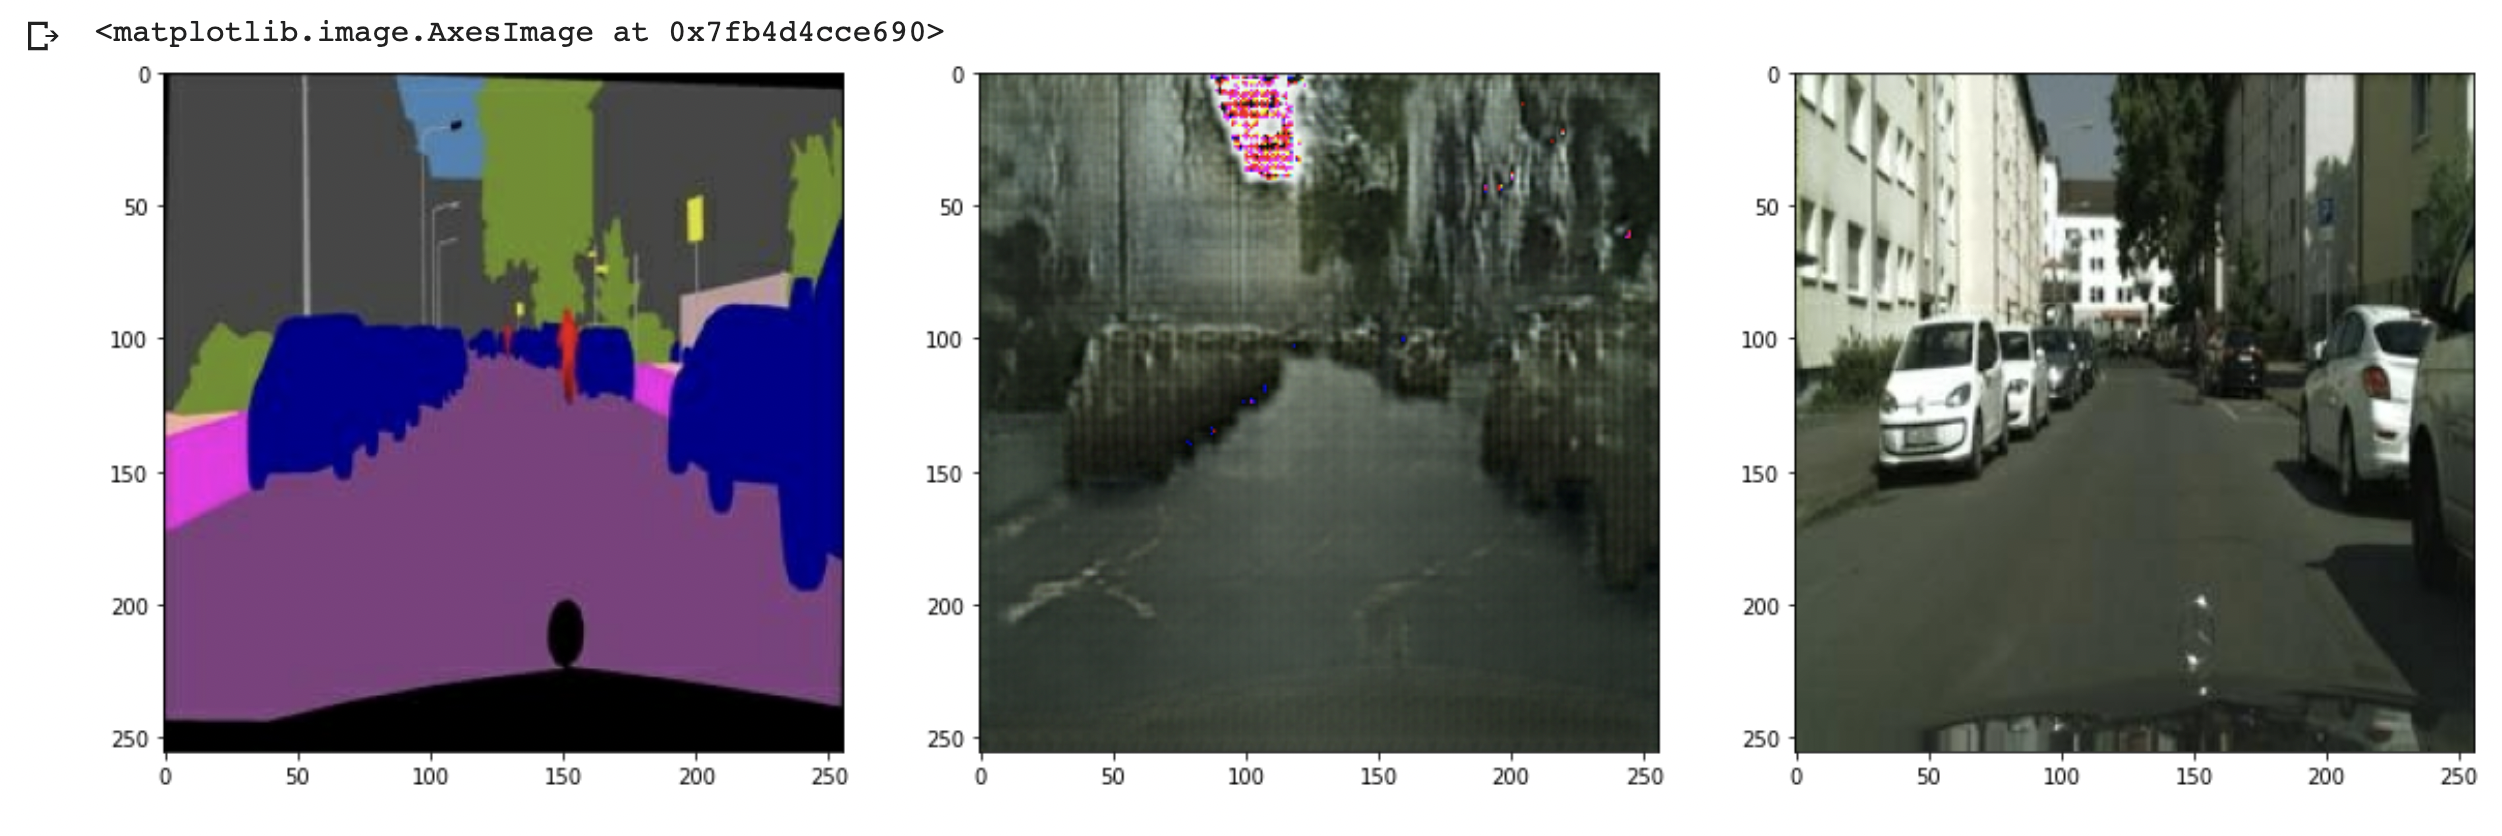

(2) epoch = 50

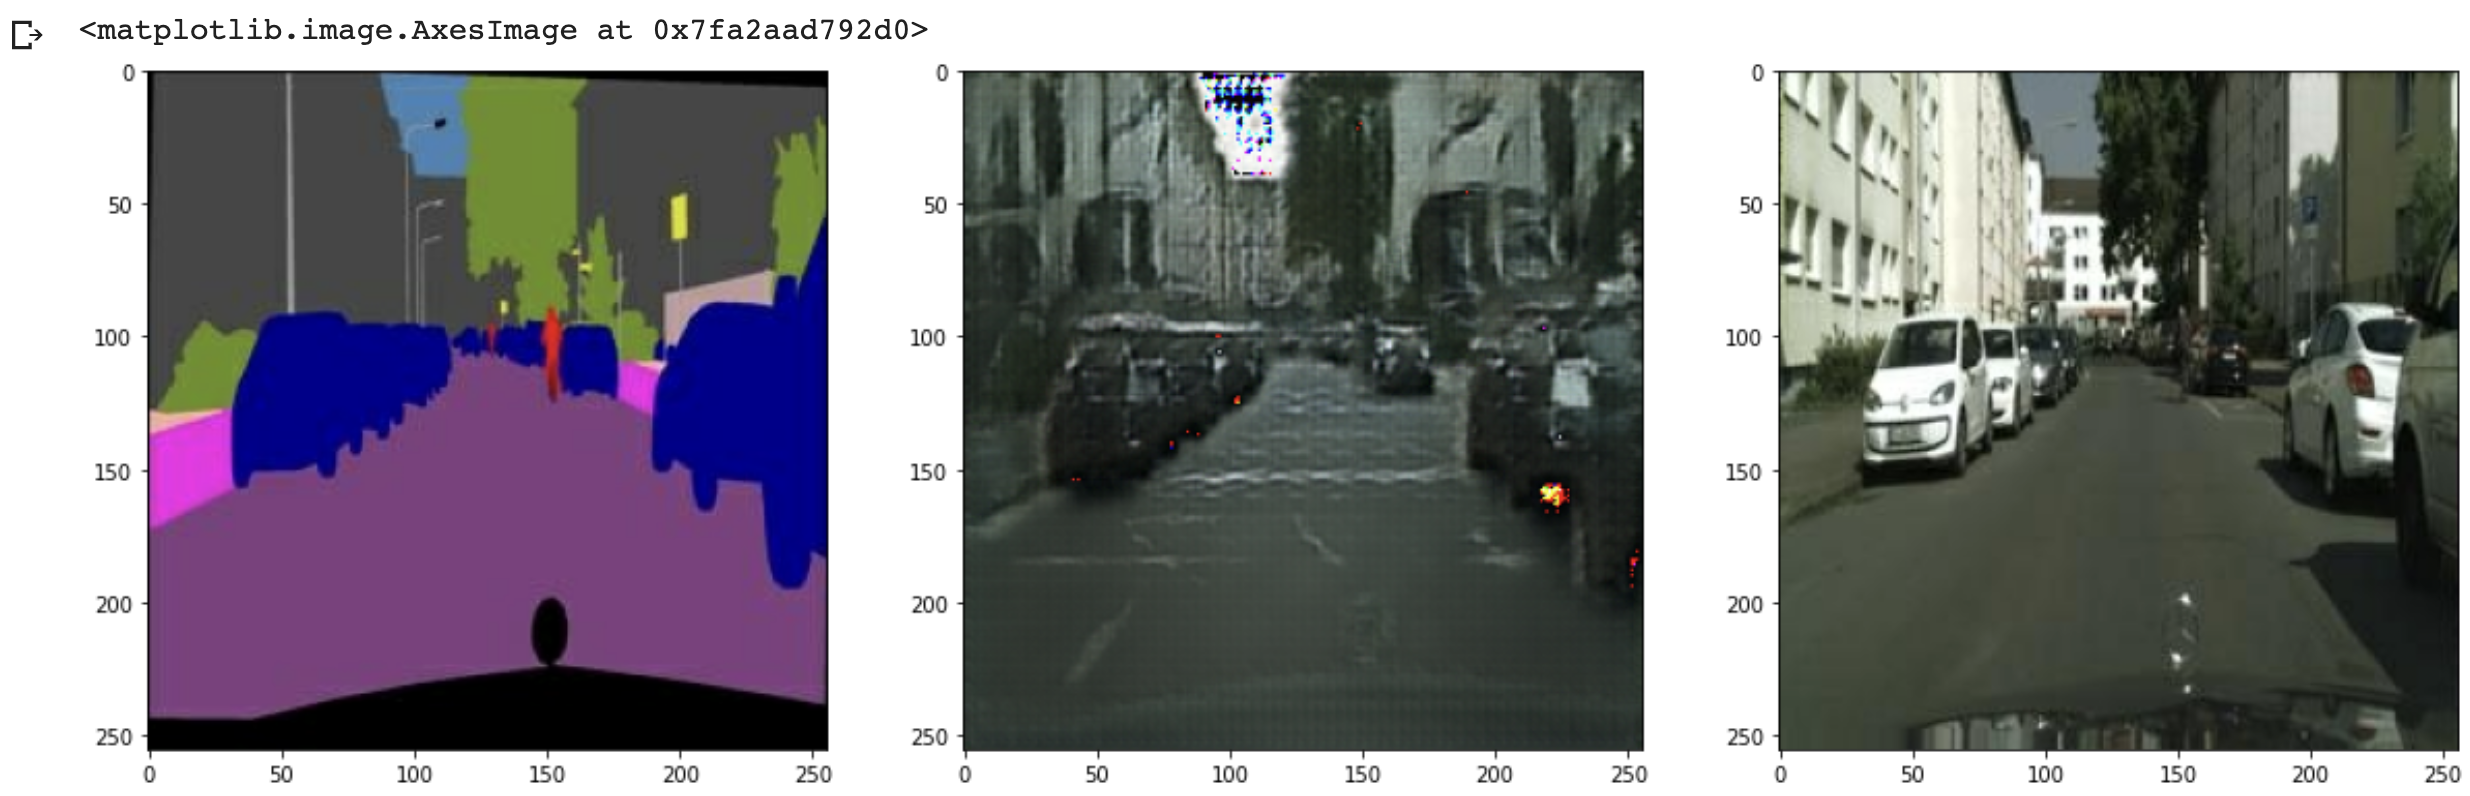

# ✏️회고
- 이번에 애먹었던 부분은 정말 단순하지만 이번에 헤매보지 않았다면 몰랐을 부분이다.  
`data_path='/content/drive/MyDrive/aiffel/cityscapes/train/'`이 부분이였는데
맨 뒤에 /를 하나 빼먹어서 error가 생겼다. 
- 처음엔 opencv의 버전 문제라고 생각했지만 계속 오류가 떠서 주미님,성보님과 함께 고민 후 오류를 발견 할 수 있었다.(혼자서 찾았으면 이렇게 빨리 못찾았겠지,,ㅎㅎ)
- 이번 프로젝트에서는 Pix2Pix모델을 활용해 진행하였는데 그 속에 generator과 discriminator을 구성하여 학습을 시키고 테스트를 해보았다.
-이런 segmentation은 한 사진안에 있는 여러물체를 구별해내기때문에 앞으로 CV를 하면서 더 많이 쓰이게 될 것같다.


## Reference
- https://velog.io/@yenaryu/Project-Segmentation-map%EC%9C%BC%EB%A1%9C-%EB%8F%84%EB%A1%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%A7%8C%EB%93%A4%EA%B8%B0
- https://zzcojoa.tistory.com/106
- https://github.com/hyunnie94/AIFFEL/blob/master/E20_conditionalGAN/%5BE20%5D%20Pix2Pix%20GAN.ipynb

